File to add corrected solar temperature profiles to netcdf Michael shared with combined and corrected simba temperatures.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime as dt
# import cmocean
import datetime
# from matplotlib.dates import DateFormatter
# import glob
# import math
# from astropy.convolution import convolve
# from matplotlib.cm import ScalarMappable
# from matplotlib.colors import Normalize
# import matplotlib as mpl
# import matplotlib.dates as mdates
# from scipy.optimize import curve_fit
import pandas as pd
# import csv
# myFmt = mdates.DateFormatter('%m-%d')

In [5]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [3]:
## simba surface that should also be saved?
## SIMBA surface from SIMBA_surface_detection_v2_split_vertical.ipynb
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')

simba_sfc_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values


In [14]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
## new adjusted temps (no smoothing)
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'
simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = dt.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]

season_data['height'] = season_data['initial_height'][::-1]
season_data['temperature'] = season_data['temperature'][:,::-1]

In [8]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'

season_data_solar = {}
varnames = ['temp','initial_height','time']
fdic = load_netcdf(fn, varnames)

fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_solar['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature':
        season_data_solar['temperature'] = fdic['temp']
    else:
        season_data_solar[var] = fdic[var]
season_data_solar['height'] = season_data_solar['initial_height']

In [10]:
print('michael',season_data['dates'][0])
print('anne',season_data_solar['dates'][0])

michael 2024-05-17 00:00:00
anne 2024-05-18 00:15:00


In [11]:
print('michael',season_data['dates'][-1])
print('anne',season_data_solar['dates'][-1])

michael 2024-08-14 23:45:00
anne 2024-07-24 23:45:00


In [15]:
print(season_data_solar['height'].shape, season_data['height'].shape)

(160,) (160,)


In [19]:
pre_add_time = len(np.where(season_data['dates']<season_data_solar['dates'][0])[0])
post_add_time = len(np.where(season_data['dates']>season_data_solar['dates'][-1])[0])

print(pre_add_time, post_add_time, season_data_solar['dates'].shape, )
print(pre_add_time+post_add_time+season_data_solar['dates'].shape[0], season_data['dates'].shape)

97 2016 (6527,)
8640 (8640,)


In [24]:
pre_array = np.full((pre_add_time, season_data['height'].shape[0]), np.nan)
post_array = np.full((post_add_time, season_data['height'].shape[0]), np.nan)

concat_solar_temp = np.ma.concatenate( (pre_array, season_data_solar['temperature']), axis=0)
concat_solar_temp = np.ma.concatenate( (concat_solar_temp, post_array), axis=0)
concat_solar_temp = np.ma.masked_invalid(concat_solar_temp)

print(concat_solar_temp.shape, season_data['temperature'].shape)

(8640, 160) (8640, 160)


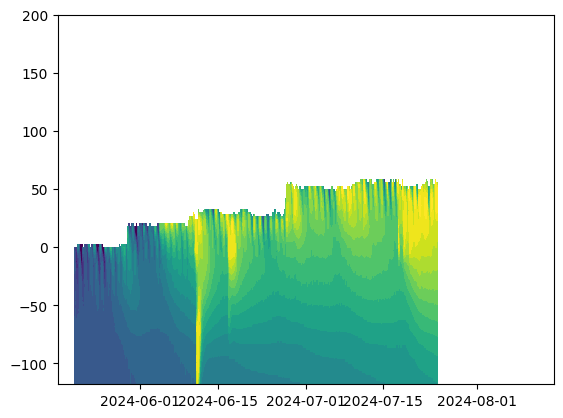

In [25]:
plt.contourf(season_data['dates'], season_data['height'], np.swapaxes(concat_solar_temp, 0,1), levels=np.linspace(-20,0,21), extend='both')
plt.show()

In [28]:
import netCDF4 as nc
# toexclude = ['ExcludeVar1', 'ExcludeVar2']

in_fn = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

out_fn = 'firnprofile-combined-corrected_solar-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr25_2025.nc'

with nc.Dataset(simba_filepath+in_fn) as src, nc.Dataset(out_fn, "w") as dst:
    # copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    # copy dimensions
    for name, dimension in src.dimensions.items():
        dst.createDimension(
            name, (len(dimension) if not dimension.isunlimited() else None))
    # copy all file data except for the excluded
    for name, variable in src.variables.items():
        # if name not in toexclude:
        x = dst.createVariable(name, variable.datatype, variable.dimensions)
        dst[name][:] = src[name][:]
        # copy variable attributes all at once via dictionary
        dst[name].setncatts(src[name].__dict__)

        if name=='temperature':
            # add corrected solar temperature
            x = dst.createVariable('temperature_solar_corrected', variable.datatype, variable.dimensions)
            dst['temperature_solar_corrected'][:] = concat_solar_temp
            dst['temperature_solar_corrected'].setncatts(src[name].__dict__)
            dst['temperature_solar_corrected'].long_name = 'temperature corrected using solar radiation and wind speed'